In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt

import _transformers

In [2]:
def train(dataloader, model, loss_fn, optimizer, lrscheduler, device):
    size = len(dataloader.dataset)
    model.train()
    loss_sum, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        lr = lrscheduler()
        optimizer.param_groups[0]['lr'] = lr

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_sum += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 10 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss_sum/(batch+1):>7f}  [{current:>5d}/{size:>5d}]  lr: {lr:>7f}", end='\x1b[1K\r')

    print(f"Train loss: {loss_sum/(batch+1):>7f}, Accuracy: {(100*(correct/size)):>0.1f}%, lr: {lr:>7f}")
    return loss_sum/(batch+1)

In [3]:
def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")
    return test_loss

In [4]:
def fit(train_dataloader, test_dataloader, model, loss_fn, optimizer, lrscheduler, epochs, device):
    losses = []
    val_losses = []
    
    model.to(device)
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses.append(train(train_dataloader, model, loss_fn, optimizer, lrscheduler, device))
        val_losses.append(test(test_dataloader, model, loss_fn, device))
    print("Done!")
    return losses, val_losses

Files already downloaded and verified
Files already downloaded and verified
Shape of x [B, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64
Range: (-1.0, 1.0)
Mean: -0.15293437242507935


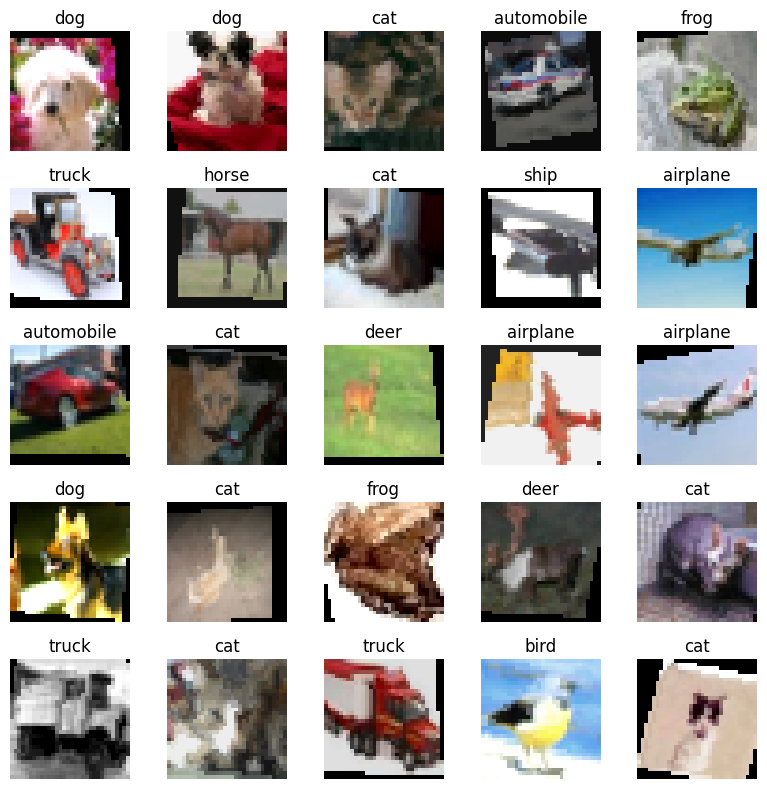

In [5]:
batch_size = 64
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_transforms = tv.transforms.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), shear=10, scale=(0.85, 1.2)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tv.transforms.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = tv.datasets.CIFAR10(    
        root="data",
        train=True,
        download=True,
        transform=train_transforms
    )

test_data = tv.datasets.CIFAR10(    
        root="data",
        train=False,
        download=True,
        transform=test_transforms
    )

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for x, y in train_dataloader:
    print(f"Shape of x [B, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Range: {torch.min(x).item(), torch.max(x).item()}\nMean: {torch.mean(x).item()}")
    plt.figure(figsize = (8, 8))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow((x[i].permute((1, 2, 0)) + 1)/2)
        plt.title(labels[y[i]])
        plt.axis('off')
    plt.tight_layout()
    break

torch.Size([64, 64, 48])


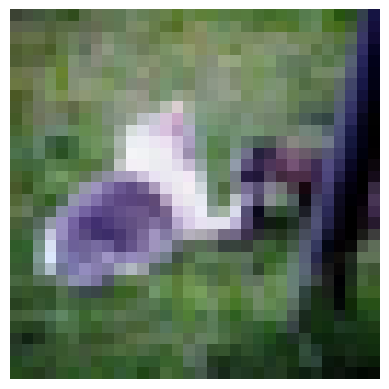

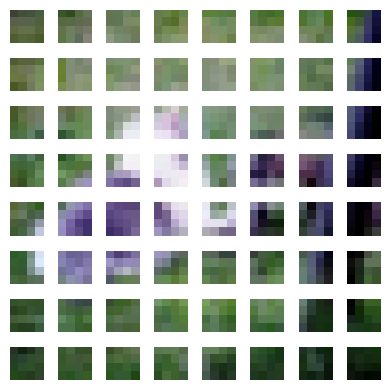

In [6]:
def patch(x, size, stride):
    B, C, H, W = x.shape
    unfolded_images = x.unfold(2, size, stride).unfold(3, size, stride) # (B, C, H//size, W//size, size, size)
    
    num_patches_H = (H - size) // stride + 1
    num_patches_W = (W - size) // stride + 1
    num_patches = num_patches_H * num_patches_W
    
    return unfolded_images.permute(0, 2, 3, 1, 4, 5).reshape(-1, num_patches, C * size * size) # (B, L, C * size * size)

for x, y in test_dataloader:
    patches = patch(x, 4, 4)
    print(patches.shape)
    plt.imshow((1 + x[0].permute((1, 2, 0))) / 2)
    plt.axis('off')
    plt.savefig('img.png', transparent=True)
    plt.show()

    plt.figure(figsize = (4, 4))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        patch_img = (1 + patches[0, i].view(3, 4, 4).permute(1, 2, 0).numpy())/2
        plt.imshow(patch_img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('img_p.png', transparent=True)
    plt.show()
    break

In [7]:
class PatchModel(nn.Module):
    def __init__(self, C, H, W, size, stride, classes, d_model, transformer):
        super(PatchModel, self).__init__()
        self.size = size
        self.stride = stride
        self.d_model = d_model
        
        self.d_p = C * size * size
        num_patches_H = (H - size) // stride + 1
        num_patches_W = (W - size) // stride + 1
        self.num_patches = num_patches_H * num_patches_W
        
        self.linear1 = nn.Linear(self.d_p, d_model)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        self.transformer = transformer
        self.linear2 = nn.Linear(d_model, classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.size, self.stride).unfold(3, self.size, self.stride) # (B, C, H//size, W//size, size, size)
        x = x.permute(0, 2, 3, 1, 4, 5).reshape(-1, self.num_patches, self.d_p) # (B, L, C * size * size)
        x = self.linear1(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1) # (B, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1) # (B, L, d_model)

        x = self.transformer(x)
        return self.linear2(x[:, 0])

In [8]:
patch_model = PatchModel(
    C=3, H=32, W=32, size=4, stride=4, classes=10, d_model=128,
    transformer = transformers.Transformer(
        blocks=8, heads=8, d_model=128, d_k=16, 
        d_v=16, d_ff=1024, a_ff=nn.ReLU, p_drop=0.1,
        pos_encoder='learned', max_length=65, e_p_drop=0.1, causal=False, 
        wk_bias=True, wv_bias=True, wo_bias=True, ff_bias=True
    )
)

lr_scheduler = transformers.LearningRateScheduler(128, 4000)
sum(p.numel() for p in patch_model.parameters() if p.requires_grad)

2654858

In [9]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(patch_model.parameters(), weight_decay=0.001)
losses, val_losses = fit(train_dataloader, test_dataloader, patch_model, loss_fn, optimizer, lr_scheduler, 200, torch.device('cuda'))

Epoch 1
-------------------------------
Train loss: 2.012310, Accuracy: 26.8%, lr: 0.000273
Test Loss: 1.846000, Accuracy: 35.1% 

Epoch 2
-------------------------------
Train loss: 1.772935, Accuracy: 39.7%, lr: 0.000546
Test Loss: 1.824902, Accuracy: 39.6% 

Epoch 3
-------------------------------
Train loss: 1.661616, Accuracy: 45.7%, lr: 0.000820
Test Loss: 1.628880, Accuracy: 47.7% 

Epoch 4
-------------------------------
Train loss: 1.629416, Accuracy: 47.4%, lr: 0.001093
Test Loss: 1.648321, Accuracy: 46.4% 

Epoch 5
-------------------------------
Train loss: 1.619188, Accuracy: 48.2%, lr: 0.001366
Test Loss: 1.557502, Accuracy: 51.2% 

Epoch 6
-------------------------------
Train loss: 1.597360, Accuracy: 49.0%, lr: 0.001290
Test Loss: 1.613854, Accuracy: 48.9% 

Epoch 7
-------------------------------
Train loss: 1.568697, Accuracy: 50.4%, lr: 0.001195
Test Loss: 1.550871, Accuracy: 51.9% 

Epoch 8
-------------------------------
Train loss: 1.542297, Accuracy: 51.6%, lr: 

In [10]:
torch.save(patch_model.state_dict(), 'vit_8_2.pt')

In [11]:
losses2, val_losses2 = fit(train_dataloader, test_dataloader, patch_model, loss_fn, optimizer, lr_scheduler, 400, torch.device('cuda'))

Epoch 1
-------------------------------
Train loss: 1.248667, Accuracy: 66.1%, lr: 0.000223
Test Loss: 1.247257, Accuracy: 66.5% 

Epoch 2
-------------------------------
Train loss: 1.247246, Accuracy: 66.2%, lr: 0.000222
Test Loss: 1.244542, Accuracy: 66.6% 

Epoch 3
-------------------------------
Train loss: 1.246760, Accuracy: 66.3%, lr: 0.000220
Test Loss: 1.219557, Accuracy: 67.7% 

Epoch 7
-------------------------------
Train loss: 1.251117, Accuracy: 66.2%, lr: 0.000220
Test Loss: 1.222014, Accuracy: 67.9% 

Epoch 8
-------------------------------
Train loss: 1.243030, Accuracy: 66.5%, lr: 0.000219
Test Loss: 1.222543, Accuracy: 67.5% 

Epoch 9
-------------------------------
Train loss: 1.247517, Accuracy: 65.9%, lr: 0.000219
Test Loss: 1.222650, Accuracy: 67.6% 

Epoch 10
-------------------------------
Train loss: 1.244014, Accuracy: 66.3%, lr: 0.000218
Test Loss: 1.214815, Accuracy: 67.9% 

Epoch 11
-------------------------------
Train loss: 1.245826, Accuracy: 66.2%, lr

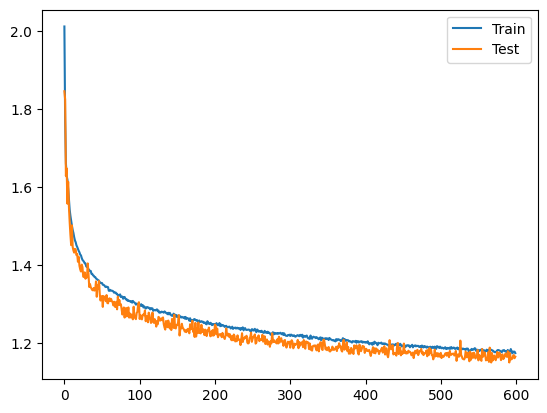

In [15]:
epochs = np.arange(len(losses) + len(losses2)) 
losses_all = np.hstack([losses, losses2])
val_losses_all = np.hstack([val_losses, val_losses2])
plt.plot(epochs, losses_all, label='Train')
plt.plot(epochs, val_losses_all, label='Test')
plt.legend()
plt.show()